In [19]:
import lucene
from org.apache.lucene.document import Document, Field
from org.apache.lucene.search import IndexSearcher, Explanation
from org.apache.lucene.search.similarities import TFIDFSimilarity, LMJelinekMercerSimilarity;
from org.apache.lucene.index import IndexReader,DirectoryReader,TermsEnum,Term
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import SimpleFSDirectory, FSDirectory
from org.apache.lucene.util import Version, BytesRefIterator
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.analysis.core import WhitespaceAnalyzer 
from org.apache.lucene.queryparser.flexible.standard import StandardQueryParser
from sklearn.utils import check_random_state
from functools import partial
import numpy as np
from java.io import File
from org.apache.lucene.analysis.en import EnglishAnalyzer
import lime
from lime import lime_ranker
import re, os
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from plotly.offline import init_notebook_mode,iplot, plot
import plotly.graph_objs as go
import plotly.plotly as py
from IPython.display import display
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import ipyparallel as ipp

In [18]:
import org.apache.lucene.document.Document
import org.apache.lucene.index.DirectoryReader
import org.apache.lucene.index.IndexReader
import org.apache.lucene.search.IndexSearcher
import org.apache.lucene.search.Query
import org.apache.lucene.search.ScoreDoc
import org.apache.lucene.search.TopDocs
import org.apache.lucene.store.FSDirectory


ModuleNotFoundError: No module named 'org.apache.lucene.document.Document'; 'org.apache.lucene.document' is not a package

In [2]:
class QRel:
    def __init__(self):
        self.query_label = {}
        self.doc_label = {}
    
    def set_rel(self, query_id, doc_id, rel_label):
        if query_id not in self.query_label:
            self.query_label[query_id] = {}
        
        self.query_label[query_id][doc_id] = rel_label
        
        if doc_id not in self.doc_label:
            self.doc_label[doc_id] = {}
        
        self.doc_label[doc_id][query_id] = rel_label
        
    def get_rel(self, query_id, doc_id):
        try:
            return self.query_label[query_id][doc_id]
        except Exception as ex:
            print(ex)
        return -1

In [3]:
# Load the samples
lucene_index_path = '/Users/manishav/workspace/irexplain/data/trec/index_old/'
samples_path = '/Users/manishav/workspace/irexplain/samples/200_sized_samples/samples_0.1_tfidf.txt'


def load_qrels(qrel_path):
    qrel = {}
    with open(qrel_path,'r') as ifile:
        for line in ifile:
            split = line.split()
    


def load_samples(file_path):
    samples_list = {}
    with open(file_path, 'r') as ifile:
        for line in ifile:
            split = line.split('\t')
            doc_id = split[1][:split[1].rindex('_')]
            try:
                index_key = (split[0],doc_id, float(split[5]))
                if index_key not in samples_list:
                    samples_list[index_key] = []
                samples_list[index_key].append({ 'sample_id':split[1], 'sample_text': split[3].strip(),\
                                         'sample_score': float(split[4])})
            except:
                print(split)
    return samples_list

#[\\\\/:*?"<>|]

def tokenize_text(text):
    # remove symbols
    ntext = re.sub(r'\W+', ' ', text)
    analyzer = EnglishAnalyzer()
    parser = StandardQueryParser(analyzer)
    parsed_text = parser.parse(ntext,'').toString('')
    parsed_text = re.sub('[)()]', '', parsed_text)
    return parsed_text


def consistancy(explanation_objects):
    '''
        Compares the relative differences in explanations for the same document accross different sampling 
    '''
    #kendall_values = {}
    scores = []
    for i in range(len(explanation_objects)):
        #kendall_values[i] = {}
        for j in range(i+1,len(explanation_objects)):
            kscore = kendalltau(explanation_objects[i],explanation_objects[j])
            if kscore[1] < 0.05:
                #kendall_values[i][j] = kscore[0] 
                scores.append(kscore[0])
    return np.mean(scores)



def divergence_from_truth(rel_vector, non_rel_vector,  explain_vector):
    
    
    # find the common words in all three vectors.    
    all_vectors = pd.DataFrame({'rel_vector': rel_vector, \
                  'non_rel_vector':non_rel_vector,\
                  'explain_vector': explain_vector}).fillna(0.0)
    
    #print(all_vectors[all_vectors['explain_vector'] > 0].head())

    norm_df = all_vectors.apply(lambda x: x/x.max(), axis=0)
    neg_ent = entropy(norm_df['non_rel_vector'].values,norm_df['explain_vector'].values )
    pos_ent = entropy(norm_df['rel_vector'].values,norm_df['explain_vector'].values )
    print(neg_ent, pos_ent, norm_df.shape)
    
    '''
    # Compute KL Divergence between relevant and non-relevant    
    neg_ent =  cosine_similarity([all_vectors['non_rel_vector'].values],\
          [all_vectors['explain_vector'].values])
    pos_ent =  cosine_similarity([all_vectors['rel_vector'].values], \
                                 [all_vectors['explain_vector'].values])
    #print(neg_ent, pos_ent, len(explain_vector), all_vectors.shape)
    '''
    
    return  neg_ent, pos_ent, neg_ent[0]/pos_ent[0]
    
    
def compute_query_document_vectors(qrel_path, lime_object):
    # Read the qrel file
    qrel_object = QRel()
    
    query_vectors = {}
    doc_counts = {}
    for line in open(qrel_path, 'r'):
        split = line.split(' ')
        query_id = split[0]
        doc_id = split[2]
        rel_label = int(split[3])
        if query_id not in query_vectors:
            query_vectors[query_id] = {}
            doc_counts[query_id] = {}
        
        if rel_label not in query_vectors[query_id]:
            query_vectors[query_id][rel_label] = {}
            doc_counts[query_id][rel_label] = 0.0
            
        qrel_object.set_rel(query_id, doc_id, rel_label)
        
        if doc_counts[query_id][rel_label] < 50:
            doc_vector = lime_object.get_document_vector(doc_id,'id','words')
       
            for entry , value in doc_vector.items():
                if entry not in query_vectors[query_id][rel_label]:
                    query_vectors[query_id][rel_label][entry] = value
                else:
                    query_vectors[query_id][rel_label][entry] += value
                
            doc_counts[query_id][rel_label] += 1.0
        
    # normalize the vectors.
    for query_id in query_vectors.keys():
        for rel_label in query_vectors[query_id].keys():
            for word in query_vectors[query_id][rel_label].keys():
                query_vectors[query_id][rel_label][word]/=doc_counts[query_id][rel_label]
        
 
    return qrel_object, query_vectors


def explanation_to_vector(word_list, explain_tuples, doc_vector):
    #print(explain_tuples)
    return dict([ (word_list[entry[0]] , doc_vector[word_list[entry[0]]]) for entry in explain_tuples])
    
    

In [4]:
#env = lucene.getVMEnv()
env = lucene.initVM(classpath=lucene.CLASSPATH, vmargs=['-Djava.awt.headless=true'])
index_path = File(lucene_index_path).toPath()
index_dir = FSDirectory.open(index_path)
reader = DirectoryReader.open(index_dir)
searcher = IndexSearcher(reader)
        

In [5]:
ranker_explanation = lime_ranker.LimeRankerExplainer(kernel_width = np.sqrt(100000) * .80,\
                                                     relevance_labels=[0,1,2,3,4],\
                                                     lucene_index_reader=reader, \
                                                     lucene_index_searcher= searcher)

In [6]:
samples = load_samples(samples_path)

['449 ', 'LA060590-0014_179', '', 'suppresses theological tremendous side intr']


In [7]:
kernel_range = np.outer(np.logspace(2,7,num=9-2+1,base=10,dtype='int')  , np.linspace(0.1, 1.0, 10)).ravel()

In [8]:
qrel_path = '/Users/manishav/workspace/irexplain/data/trec/qrels/qrels.trec8.adhoc'
qrel_object, query_vectors = compute_query_document_vectors(qrel_path, ranker_explanation)

In [18]:
def compute_metrics(top_k):
    consistancy_scores=[]
    divergence_scores=[]
    query_count = {}
    for index_key, sample_list in samples.items():
        # index_key --> query_id, doc_id, doc_score
        query_id = index_key[0].strip()
        if query_id not in query_count:
            print('Evaluating for query', index_key[0], top_k)
            query_count[query_id] = 0
        query_count[query_id] +=1
        
        sample_scores = [x['sample_score'] for x in sample_list]
        sample_texts = [tokenize_text(x['sample_text']) for x in sample_list]
        document_dict = ranker_explanation.get_document_vector(index_key[1],\
                                                    'id','words')
        doc_label = qrel_object.get_rel(query_id, index_key[1])
        word_list = list(document_dict.keys())
        
        explain_objects = ranker_explanation.explain_document_label(document_dict, index_key[2],\
                                                               sample_texts, sample_scores, top_k,\
                                                                weights_range=kernel_range)
        ranked_lists = []
        for eobject, kernel in zip(explain_objects, kernel_range):
            ranked_lists.append([entry[0] for entry in sorted(eobject.local_exp[1],\
                                                              key = lambda x: x[1],\
                                                              reverse=True)])
            ne, pe, dfr = divergence_from_truth(query_vectors[query_id][1],query_vectors[query_id][0],\
                                                                            explanation_to_vector(word_list,\
                                                                            eobject.local_exp[1],\
                                                                            document_dict))
            divergence_scores.append({'doc_id':index_key[1],'top_feat':top_k, 'kernel':kernel, \
                                                'doc_rel':doc_label ,'doc_score':index_key[2], \
                                                'dfr': dfr, 'ne': ne, 'pe':pe, 'query_id': query_id} )
                
        consistancy_scores.append({'doc_id':index_key[1], 'ktau': consistancy(ranked_lists),\
                                                 'doc_score':index_key[2],'top_feat':top_k,\
                                                 'doc_rel':doc_label})
    return consistancy_scores, divergence_scores


In [64]:
L = sorted([(k, k1['doc_id'], k1['doc_score'], k1['ktau'],\
             k1['doc_rel'], k1['top_feat']) for k,v in consistancy_scores.items() for k1 in v], 
            key=lambda x: (x[0], x[1]))
query_consistancy_frame = pd.DataFrame(L, columns=['query_id','doc_id','doc_score', 'ktau', 'doc_rel', 'top_feat'])
query_consistancy_frame.to_csv('kendal_score.csv', sep=',')

In [55]:
init_notebook_mode(connected=True)
data = []
for q in query_consistancy_frame['query_id'].unique():
    trace = go.Scatter(
        x = query_consistancy_frame[query_consistancy_frame['query_id'] == q]['doc_score'],
        y = query_consistancy_frame[query_consistancy_frame['query_id'] == q]['ktau'],
        mode = 'markers', name = q)
    data.append(trace)

layout = dict(title = 'Consistancy scores across queries',
              yaxis = dict(title ='Consistency score' ),
              xaxis = dict(title = "Document Ranker score")
             )
iplot(go.Figure(data=data, layout=layout))

In [ ]:
L = sorted([(k, k1['doc_id'], k1['doc_score'], k1['dfr'], k1['ne'], k1['pe'], k1['kernel'],\
             k1['doc_rel'], k1['top_feat']) for k,v in divergence_scores.items() for k1 in v], 
            key=lambda x: (x[0], x[1]))
df = pd.DataFrame(L, columns=['query_id','doc_id','doc_score', 'dfr','ne','pe', 'kernel',\
                                                   'doc_rel', 'top_feat'])
df.to_csv('divergence_score.csv', sep=',')

uniform_mask_0.3_kendal_score20.csv nan
uniform_mask_0.3_kendal_score20.csv doc_rel
0   NaN
1   NaN
Name: ktau, dtype: float64
uniform_mask_0.3_divergence_scores15.csv
kernel
1    0.923827
Name: dfr, dtype: float64
uniform_mask_0.3_divergence_scores10.csv
kernel
1    0.912261
Name: dfr, dtype: float64
uniform_mask_0.3_kendal_score25.csv nan
uniform_mask_0.3_kendal_score25.csv doc_rel
0   NaN
1   NaN
Name: ktau, dtype: float64
uniform_mask_0.3_kendal_score30.csv nan
uniform_mask_0.3_kendal_score30.csv doc_rel
0   NaN
1   NaN
Name: ktau, dtype: float64
uniform_mask_0.3_kendal_score15.csv nan
uniform_mask_0.3_kendal_score15.csv doc_rel
0   NaN
1   NaN
Name: ktau, dtype: float64
uniform_mask_0.3_divergence_scores20.csv
kernel
1    0.932301
Name: dfr, dtype: float64
uniform_mask_0.3_divergence_scores30.csv
kernel
1    0.94441
Name: dfr, dtype: float64
uniform_mask_0.3_divergence_scores25.csv
kernel
1    0.9396
Name: dfr, dtype: float64
uniform_mask_0.3_kendal_score10.csv nan
uniform_mask_0.

ParserError: Error tokenizing data. C error: Expected 1 fields in line 6, saw 320


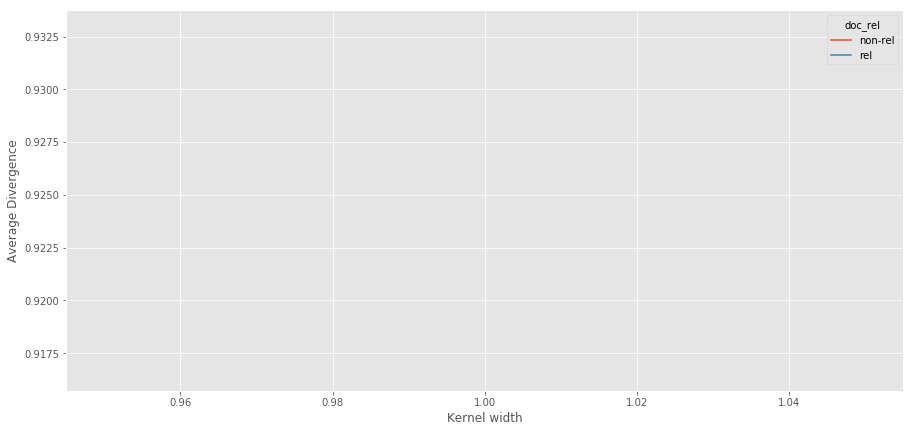

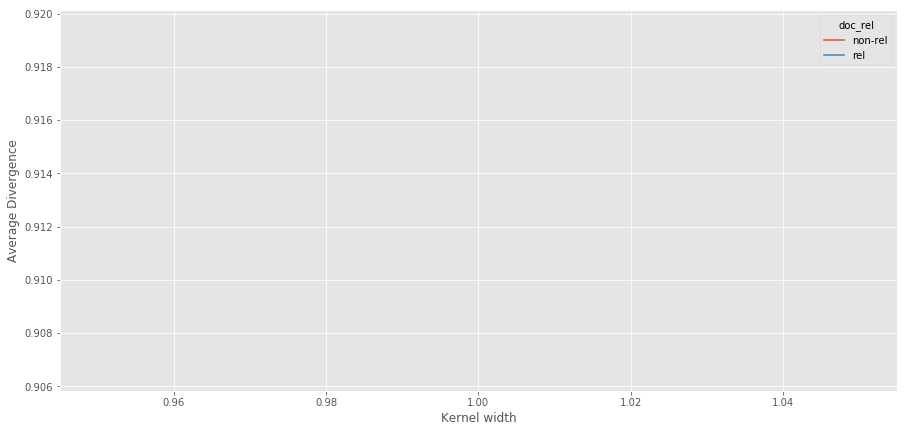

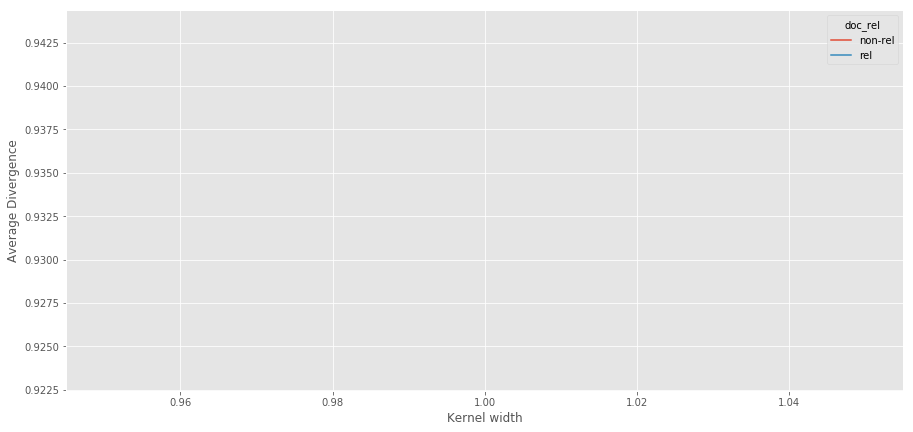

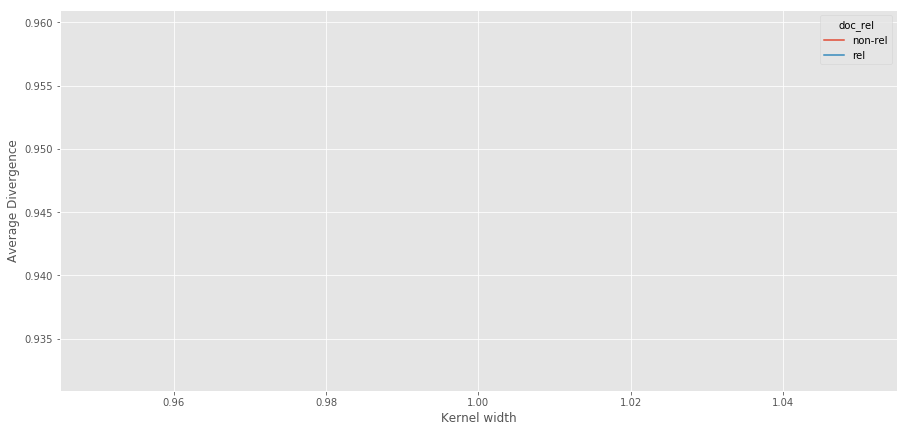

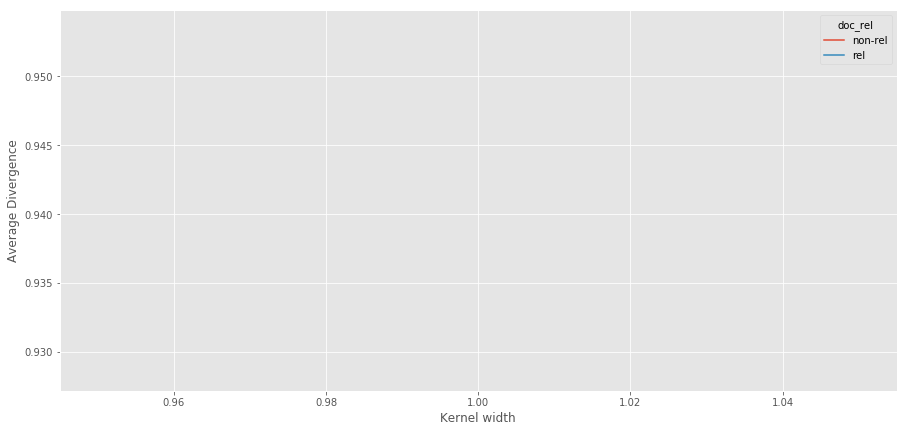

In [15]:
%matplotlib inline

#set ggplot style
plt.style.use('ggplot')

dpath = '/Users/manishav/workspace/irexplain/src/main/python/explain/uniform_kernel/mask/'
for ifile in os.listdir(dpath):
    # read the file and get the average.
    if 'kendal' in ifile:
        frame = pd.read_csv(dpath+'/'+ifile, sep=',')
        print(ifile, frame['ktau'].mean())
        print(ifile, frame.groupby('doc_rel')['ktau'].agg(np.mean))
    else:
        frame = pd.read_csv(dpath+'/'+ifile, sep=',')
        print(ifile)
        print(frame[frame['kernel'].isin([1,10,100,1000.0,10000.0,1000000.0])].groupby(['kernel'])['dfr'].agg(np.mean))
        fig, ax = plt.subplots(figsize=(15,7))
        frame['doc_rel']= frame['doc_rel'].map({1:'rel', 0:'non-rel'})
        frame[frame['kernel'] < 1000].groupby(['kernel','doc_rel'])['dfr'].agg(np.mean).unstack().plot(ax=ax)
        ax.set_xlabel('Kernel width')
        ax.set_ylabel('Average Divergence')
        fig.savefig(ifile+'.png')
        

In [ ]:
lucene.initVM(classpath=lucene.CLASSPATH, vmargs=['-Djava.awt.headless=true'])
analyzer = StandardAnalyzer()
print(lucene.CLASSPATH)

In [ ]:
tokenize_text('2790-0091 youths passengers staff diplomatic center 182123 77 77 182123 wire suffered')
indexPath = File(index_path).toPath()
index_dir = FSDirectory.open(indexPath)
reader = DirectoryReader.open(index_dir)
searcher = IndexSearcher(reader)

text_field = 'words'
analyzer = WhitespaceAnalyzer()
query_parser = QueryParser('id', analyzer)
score_docs = searcher.search(query_parser.parse(str('LA022790-0091')),1).scoreDocs

In [ ]:
import math
tc_dict = {}                     # Counts of each term
dc_dict = {}                     # Number of docs associated with each term
tfidf_dict = {}   
if len(score_docs) > 0:
    # get the tf-idf vector.
    termVector = reader.getTermVector(score_docs[0].doc, text_field);
    termsEnumvar = termVector.iterator()
    termsref = BytesRefIterator.cast_(termsEnumvar)
    N_terms = 0
    try:
        while (termsref.next()):
            termval = TermsEnum.cast_(termsref)
            fg = termval.term().utf8ToString()       # Term in unicode
            tc = termval.totalTermFreq()             # Term count in the doc

            # Number of docs having this term in the index
            dc = reader.docFreq(Term(text_field, termval.term())) 
            N_terms = N_terms + 1 
            tc_dict[fg]=tc
            dc_dict[fg]=dc
    except:
        print('error in term_dict')

    # Compute TF-IDF for each term
    for term in tc_dict:
        tf = tc_dict[term] / N_terms
        idf = 1 + math.log(reader.numDocs()/(dc_dict[term]+1)) 
        tfidf_dict[term] = tf*idf
